Нам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.datasets import load_boston

In [2]:
boston = load_boston()

X = boston["data"]
y = boston["target"]

In [3]:
X.shape, y.shape

((506, 13), (506,))

Ошибку алгоритма регрессии в виде суммы трех компонент: шум, смещение и разброс $$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.

С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [4]:
z = np.random.normal(loc=5, scale=3, size=2000)
(z**2).mean()

34.74701525578927

Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

Итоговый алгоритм оценки смещения и разброса алгоритма $a$:
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса.

---

Реализуем описанный алгоритм. Обратим внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно.

Для подсчета $S^2$ на лету используем quick math:
$$
    S^2 = \frac{1}{n}\sum_{i=1}^{n} (X_i - \bar{X})^2 = \frac{1}{n} \sum_{i=1}^{n} (X_i^2 - 2 X_i \bar{X} + \overline{X}^2) = \overline{X^2} - \overline{X}^2 
$$
Поэтому достаточно поддерживать лишь первый и второй момент для вычисления выборочной дисперсии:

In [5]:
def compute_bias_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """

    n_obj = X.shape[0]
    n_feat = X.shape[1]
    N = int(0.5 * n_obj)
    
    error = np.zeros(n_obj)
    numb_predicts = np.zeros(n_obj)
    mean_predicts = np.zeros(n_obj)
    sqr_predicts = np.zeros(n_obj)
    
    for run in range(num_runs):
        indecies = np.sort(np.random.choice(n_obj, N, replace=True))
        test_indecies = np.sort(np.setdiff1d(np.arange(n_obj), indecies))
        
        X_train, y_train = X[indecies], y[indecies]
        X_test, y_test = X[test_indecies], y[test_indecies]
        
        alg = regressor.fit(X_train, y_train)
        y_pred = alg.predict(X_test)
            
        numb_predicts[test_indecies] += 1
        mean_predicts[test_indecies] += y_pred
        sqr_predicts[test_indecies] += y_pred**2
        error[test_indecies] += (y_test - y_pred)**2
        
    samples = numb_predicts > 0
    error[samples] /= numb_predicts[samples]
    mean_predicts[samples] /= numb_predicts[samples]
    sqr_predicts[samples] /= numb_predicts[samples]
    
    
    bias = ((mean_predicts[samples] - y[samples])**2).mean()
    variance = (sqr_predicts[samples] - mean_predicts[samples]**2).mean()
    error = error[samples].mean()
    
    return bias, variance, error

Оценим смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес:

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [7]:
print("BVD for LinearRegression:", compute_bias_variance( LinearRegression(), X, y) )
print("BVD for DecisionTreeRegressor:", compute_bias_variance( DecisionTreeRegressor(), X, y) )
print("BVD for RandomForestRegressor:", compute_bias_variance( RandomForestRegressor(n_estimators=10), X, y) )

BVD for LinearRegression: (23.762086765299777, 2.010073984481745, 25.77216074978146)
BVD for DecisionTreeRegressor: (11.200194707667027, 15.522854408599153, 26.7230491162667)
BVD for RandomForestRegressor: (12.327195399822376, 4.290163017060038, 16.617358416882386)


Линейная модель имеет малое смещение, если в данных действительно линейная зависимость, и большое, если это не так. Как видим, данные у нас совсем не линейны, поэтому смещение ожидаемое, разброс должен был быть мал при малом шуме, шум действительно мал (можно отнять суммарную ошибку от суммы смещения и разброса и увидеть очень маленькие цифры).

Решающее дерево - такие модели действительно имеют малое смещение, потому что почти на любом датасете можно обучить дерево, которое абсолютно точно предсказывает ответ, но при этом разброс достаточно большой из-за высокой чувствительности к начальным данным.

Случайный лес имеет такое же смещение, что и дерево, но при этом разброс значительно меньше. Композиция алгоритмов работает строго по теории.

В идеале бэггинг должен уменьшать разброс в N раз, где N - количество базовых моделей, а шум и смещение не изменять, но можно пронаблюдать, что в случае нашего случайного леса (то есть бэггинга над решающими деревьями), при 10 деревьях мы получили понижения  разброса всего в ~4 раза, это связано напрямую с очень сильным предположением для оценки ошибки выше - все алгоритмы должны быть малокоррелированы, а у нас данных очень мало (всего 506 записей) и ожидать некореллированости какой либо не приходится. При этом стоит заметить, что предположение о постоянстве смещения практически выполнено.

---

Реализуем фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбирать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Генерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и делать предсказания для X_test.
1. Рисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта отмечает одним цветом все предсказания для него, а также черным цветом отмечает правильный ответ.
1. Подписывает оси и название графика (аргумент title).

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=None):
    predicts = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=42)
    n_train = X_train.shape[0]
    N = int(0.5 * n_train)
    
    for run in range(num_runs):
        indecies = np.sort(np.random.choice(n_train, N, replace=True))
        X_boot, y_boot = X_train[indecies], y_train[indecies]
        
        alg = regressor.fit(X_boot, y_boot)
        y_pred = alg.predict(X_test)
        predicts.append(y_pred)
    predicts = np.array(predicts)

    objs = np.arange(num_test_objects)
    
    if ax is None:
        ax = plt.gca()
    
    ax.set_xticks(objs)
    ax.grid(alpha=0.3)
    
    ax.set_title(title)
    ax.set_xlabel('Objects')
    ax.set_ylabel('Target')
    
    ax.scatter(np.tile(objs, num_runs), predicts.flatten(), color='blue')
    ax.scatter(objs, y_test, color='black')

Нарисуем графики для линейной регрессии, решающего дерева и случайного леса (три графика в строчку с одинаковой осью ординат):

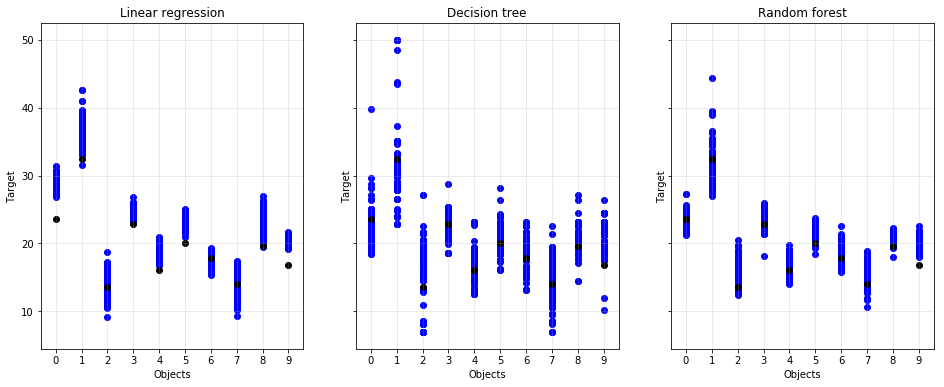

In [10]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))

plot_predictions( LinearRegression(), X, y, title="Linear regression", ax=axs[0] )
plot_predictions( DecisionTreeRegressor(), X, y, title="Decision tree", ax=axs[1] )
plot_predictions( RandomForestRegressor(n_estimators=10), X, y, title="Random forest", ax=axs[2] )

В линейной регрессии смещение видно невооруженным взглядом, но разброс достаточно мал (сравнительно с решающим деревом).

Решающее дерево в среднем гораздо лучше сконцентировано вокруг истинного значения, но большое число выбросов несколько портит итоговый ответ модели.

Случайный лес исправляет главный недостаток решающего дерева и избавляет нас от выбросов, хотя полученный разброс все равно несколько больше, чем у регрессии. Также наследуется лучшее свойство решающего дерева: малая смещенность.

---

Построим графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [11]:
depth_bias = []
depth_variance = []
depths = np.arange(1, 11)
for d in depths:
    bias, var, _ = compute_bias_variance(DecisionTreeRegressor(max_depth=d), X, y)
    depth_bias.append(bias)
    depth_variance.append(var)

In [12]:
feat_bias = []
feat_variance = []
features = np.arange(1, X.shape[1])
for f in features:
    bias, var, _ = compute_bias_variance(DecisionTreeRegressor(max_features=f), X, y)
    feat_bias.append(bias)
    feat_variance.append(var)

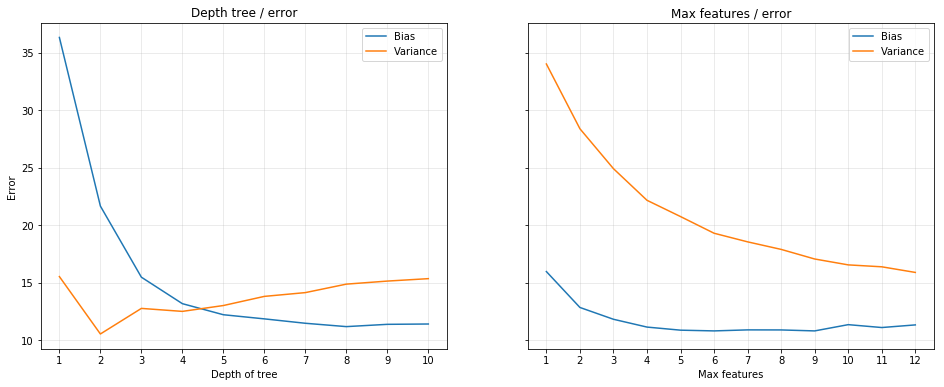

In [13]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,6))
    
axs[0].set_xticks(depths)
axs[0].grid(alpha=0.3)   
axs[0].set_title('Depth tree / error')
axs[0].set_xlabel('Depth of tree')
axs[0].set_ylabel('Error')
    
axs[0].plot(depths, depth_bias, label='Bias')
axs[0].plot(depths, depth_variance, label='Variance')
axs[0].legend()

axs[1].set_xticks(features)
axs[1].grid(alpha=0.3)  
axs[1].set_title('Max features / error')
axs[1].set_xlabel('Max features')
    
axs[1].plot(features, feat_bias, label='Bias')
axs[1].plot(features, feat_variance, label='Variance')
axs[1].legend()

plt.show()

Уменьшение глубины дерева ухудшает способности дерева обучаться, оно не может как либо подстроится даже под обучающую выборку, поэтому смещение поначалу большое. С другой стороны, модель проще, поэтому разброс при малой глубине небольшой: вполне однозначно дает ответы и не так значительно подстраиваемся под выборку.

Выбирание признака max_features случайным образом резко увеличивает разброс -- наш алгоритм начинает больше полагаться на случайность и от раза к разу восстановить прошлые предсказания и как-то их стабилизировать становится сложнее. Также при этом за счет ухудшения возможности к обучению при малом значении рассматриваемых признаков возрастает и разброс.

Оптимальная глубина дерева либо 4, либо 5 (нужно тестировать), а оптимальное число фич, которые рассмтариваются при сплите в дереве, где-то за горизонтом справа.

Построим графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 7)) для случайного леса и градиентного бустинга:

In [14]:
from sklearn.ensemble import GradientBoostingRegressor 

In [15]:
n_estimators = 2**np.arange(1,7)

bagging_bias = []
bagging_variance = []
boosting_bias = []
boosting_variance = []

for n in n_estimators:
    bias, var, _ = compute_bias_variance(RandomForestRegressor(n_estimators=n), X, y)
    bagging_bias.append(bias)
    bagging_variance.append(var)
    
    bias, var, _ = compute_bias_variance(GradientBoostingRegressor(n_estimators=n), X, y)
    boosting_bias.append(bias)
    boosting_variance.append(var)

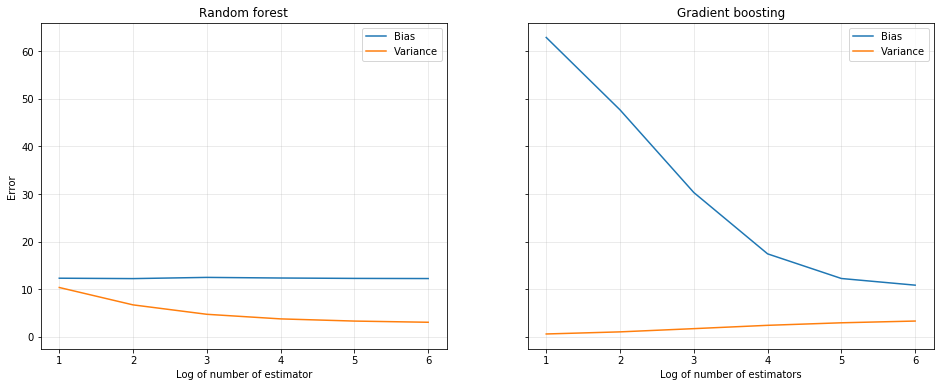

In [16]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,6))
    
axs[0].set_xticks(np.arange(1,7))
axs[0].grid(alpha=0.3)    
axs[0].set_title('Random forest')
axs[0].set_xlabel('Log of number of estimator')
axs[0].set_ylabel('Error')
    
axs[0].plot(np.arange(1,7), bagging_bias, label='Bias')
axs[0].plot(np.arange(1,7), bagging_variance, label='Variance')
axs[0].legend()

axs[1].set_xticks(np.arange(1,7))
axs[1].grid(alpha=0.3)
axs[1].set_title('Gradient boosting')
axs[1].set_xlabel('Log of number of estimators')
    
axs[1].plot(np.arange(1,7), boosting_bias, label='Bias')
axs[1].plot(np.arange(1,7), boosting_variance, label='Variance')
axs[1].legend()

plt.show()

У случайного леса смещение константно, как и говорит соответствующая теория, при этом дисперсия падает не линейно в виду высокой корелляции моделей (на 500 сэмплах много принципиально разных деревьев не построишь), но все равно снижается.

По классическому построению градиентного бустинга используются деревья небольшой глубины, поэтому в самом начале можно увидеть как раз разброс одного неглубокого дерева, затем количество деревьев нарастает и они начинают исправлять ошибки друг друга, приводя к приличной модели начиная с 64 деревьев. Причина маленькой дисперсии заключена в высокой обобщающей способности неглубоких деревьев, потом все же за счет большого количества алгоритмов их суммарная дисперсия потихоньку набегает и становится немного больше.